# King County - Polynomial Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Normalization
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from k_mean_cluster_util import k_mean_optimization

## Getting data ready
First We'll have some intuition on the data and set the "id" as index value. Also remove duplicate values.

In [2]:
df = pd.read_csv('./kc_house_data.csv')
df.set_index('id', inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.drop(['zipcode', 'waterfront', 'date'], axis=1)
prices = df['price']
df = df.drop('price', axis=1)
df['price'] = prices
df.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  \
id                                                                     
7129300520         3       1.00         1180      5650     1.0     0   
6414100192         3       2.25         2570      7242     2.0     0   
5631500400         2       1.00          770     10000     1.0     0   
2487200875         4       3.00         1960      5000     1.0     0   
1954400510         3       2.00         1680      8080     1.0     0   

            condition  grade  sqft_above  sqft_basement  yr_built  \
id                                                                  
7129300520          3      7        1180              0      1955   
6414100192          3      7        2170            400      1951   
5631500400          3      6         770              0      1933   
2487200875          5      7        1050            910      1965   
1954400510          3      8        1680              0      1987   

            yr_renovated      lat     long  sqft_living15  sqft_lot15  \
id                                                                      
7129300520             0  47.5112 -122.257           1340        5650   
6414100192          1991  47.7210 -122.319           1690        7639   
5631500400             0  47.7379 -122.233           2720        8062   
2487200875             0  47.5208 -122.393           1360        5000   
1954400510             0  47.6168 -122.045           1800        7503   

               price  
id                    
7129300520  221900.0  
6414100192  538000.0  
5631500400  180000.0  
2487200875  604000.0  
1954400510  510000.0

From date which is an object, "str" in this dataset, we'll have to convert to date and take year and month which is important to our model.

In [3]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df = df.drop('date', axis=1)
# df.head()

Have an intuition on what columns contain null values and what their Dtypes are

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 7129300520 to 1523300157
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21436 non-null  int64  
 1   bathrooms      21436 non-null  float64
 2   sqft_living    21436 non-null  int64  
 3   sqft_lot       21436 non-null  int64  
 4   floors         21436 non-null  float64
 5   view           21436 non-null  int64  
 6   condition      21436 non-null  int64  
 7   grade          21436 non-null  int64  
 8   sqft_above     21436 non-null  int64  
 9   sqft_basement  21436 non-null  int64  
 10  yr_built       21436 non-null  int64  
 11  yr_renovated   21436 non-null  int64  
 12  lat            21436 non-null  float64
 13  long           21436 non-null  float64
 14  sqft_living15  21436 non-null  int64  
 15  sqft_lot15     21436 non-null  int64  
 16  price          21436 non-null  float64
dtypes: float64(5), int64(12)
memory usag

In [5]:
df.describe().T

count           mean            std         min          25%  \
bedrooms       21436.0       3.371571       0.929205      0.0000       3.0000   
bathrooms      21436.0       2.117349       0.769913      0.0000       1.7500   
sqft_living    21436.0    2082.704936     919.146469    290.0000    1430.0000   
sqft_lot       21436.0   15135.637852   41538.620606    520.0000    5040.0000   
floors         21436.0       1.496198       0.540388      1.0000       1.0000   
view           21436.0       0.235118       0.767092      0.0000       0.0000   
condition      21436.0       3.410384       0.650235      1.0000       3.0000   
grade          21436.0       7.661737       1.174256      1.0000       7.0000   
sqft_above     21436.0    1790.960440     829.026491    290.0000    1200.0000   
sqft_basement  21436.0     291.744495     442.781983      0.0000       0.0000   
yr_built       21436.0    1971.098433      29.385277   1900.0000    1952.0000   
yr_renovated   21436.0      84.729800     402.431012      0.0000       0.0000   
lat            21436.0      47.560156       0.138601     47.1559      47.4711   
long           21436.0    -122.213697       0.140896   -122.5190    -122.3280   
sqft_living15  21436.0    1988.314378     685.699093    399.0000    1490.0000   
sqft_lot15     21436.0   12785.961280   27375.467469    651.0000    5100.0000   
price          21436.0  540529.287180  367689.296471  75000.0000  322150.0000   

                      50%         75%           max  
bedrooms            3.000       4.000  3.300000e+01  
bathrooms           2.250       2.500  8.000000e+00  
sqft_living      1920.000    2550.000  1.354000e+04  
sqft_lot         7614.000   10696.250  1.651359e+06  
floors              1.500       2.000  3.500000e+00  
view                0.000       0.000  4.000000e+00  
condition           3.000       4.000  5.000000e+00  
grade               7.000       8.000  1.300000e+01  
sqft_above       1560.000    2220.000  9.410000e+03  
sqft_basement       0.000     560.000  4.820000e+03  
yr_built         1975.000    1997.000  2.015000e+03  
yr_renovated        0.000       0.000  2.015000e+03  
lat                47.572      47.678  4.777760e+01  
long             -122.230    -122.124 -1.213150e+02  
sqft_living15    1840.000    2370.000  6.210000e+03  
sqft_lot15       7620.000   10087.250  8.712000e+05  
price          450000.000  645000.000  7.700000e+06

In [6]:
(df == 0).sum()

bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
view             19320
condition            0
grade                0
sqft_above           0
sqft_basement    13015
yr_built             0
yr_renovated     20526
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price                0
dtype: int64

Correlation of two values gives a great insight on what features impact the values of each other

In [7]:
df.corr()

bedrooms  bathrooms  sqft_living  sqft_lot    floors      view  \
bedrooms       1.000000   0.516772     0.577512  0.031719  0.175207  0.079542   
bathrooms      0.516772   1.000000     0.754422  0.087143  0.499863  0.186684   
sqft_living    0.577512   0.754422     1.000000  0.171957  0.352867  0.283753   
sqft_lot       0.031719   0.087143     0.171957  1.000000 -0.005950  0.075012   
floors         0.175207   0.499863     0.352867 -0.005950  1.000000  0.028211   
view           0.079542   0.186684     0.283753  0.075012  0.028211  1.000000   
condition      0.027896  -0.127839    -0.060973 -0.009298 -0.266543  0.045051   
grade          0.358396   0.664727     0.762402  0.112541  0.457475  0.249890   
sqft_above     0.478441   0.684994     0.876683  0.182581  0.522648  0.166930   
sqft_basement  0.303035   0.283539     0.434419  0.015107 -0.246066  0.276482   
yr_built       0.153745   0.505092     0.316544  0.052447  0.489062 -0.055153   
yr_renovated   0.018435   0.051101     0.055084  0.007636  0.005626  0.103633   
lat           -0.010228   0.023444     0.051118 -0.085992  0.049279  0.005671   
long           0.129836   0.221935     0.239214  0.229555  0.124285 -0.079720   
sqft_living15  0.393161   0.568194     0.756205  0.143650  0.278854  0.279077   
sqft_lot15     0.029117   0.086627     0.182775  0.718097 -0.011917  0.072867   
price          0.309007   0.525453     0.701993  0.088895  0.256278  0.396933   

               condition     grade  sqft_above  sqft_basement  yr_built  \
bedrooms        0.027896  0.358396    0.478441       0.303035  0.153745   
bathrooms      -0.127839  0.664727    0.684994       0.283539  0.505092   
sqft_living    -0.060973  0.762402    0.876683       0.434419  0.316544   
sqft_lot       -0.009298  0.112541    0.182581       0.015107  0.052447   
floors         -0.266543  0.457475    0.522648      -0.246066  0.489062   
view            0.045051  0.249890    0.166930       0.276482 -0.055153   
condition       1.000000 -0.148248   -0.160782       0.174463 -0.364947   
grade          -0.148248  1.000000    0.756068       0.167032  0.445329   
sqft_above     -0.160782  0.756068    1.000000      -0.052456  0.422838   
sqft_basement   0.174463  0.167032   -0.052456       1.000000 -0.134590   
yr_built       -0.364947  0.445329    0.422838      -0.134590  1.000000   
yr_renovated   -0.061136  0.014357    0.022666       0.071909 -0.225697   
lat            -0.015402  0.113332   -0.001652       0.109208 -0.148606   
long           -0.107780  0.196572    0.343115      -0.145846  0.408531   
sqft_living15  -0.095002  0.712507    0.731992       0.199247  0.324568   
sqft_lot15     -0.003731  0.118313    0.193413       0.017283  0.070307   
price           0.035089  0.667496    0.605495       0.323552  0.052967   

               yr_renovated       lat      long  sqft_living15  sqft_lot15  \
bedrooms           0.018435 -0.010228  0.129836       0.393161    0.029117   
bathrooms          0.051101  0.023444  0.221935       0.568194    0.086627   
sqft_living        0.055084  0.051118  0.239214       0.756205    0.182775   
sqft_lot           0.007636 -0.085992  0.229555       0.143650    0.718097   
floors             0.005626  0.049279  0.124285       0.278854   -0.011917   
view               0.103633  0.005671 -0.079720       0.279077    0.072867   
condition         -0.061136 -0.015402 -0.107780      -0.095002   -0.003731   
grade              0.014357  0.113332  0.196572       0.712507    0.118313   
sqft_above         0.022666 -0.001652  0.343115       0.731992    0.193413   
sqft_basement      0.071909  0.109208 -0.145846       0.199247    0.017283   
yr_built          -0.225697 -0.148606  0.408531       0.324568    0.070307   
yr_renovated       1.000000  0.029206 -0.068736      -0.002677    0.007870   
lat                0.029206  1.000000 -0.136369       0.047668   -0.086505   
long              -0.068736 -0.136369  1.000000       0.333652    0.254280   
sqft_living15     -0.002677  0.0476

<AxesSubplot:>

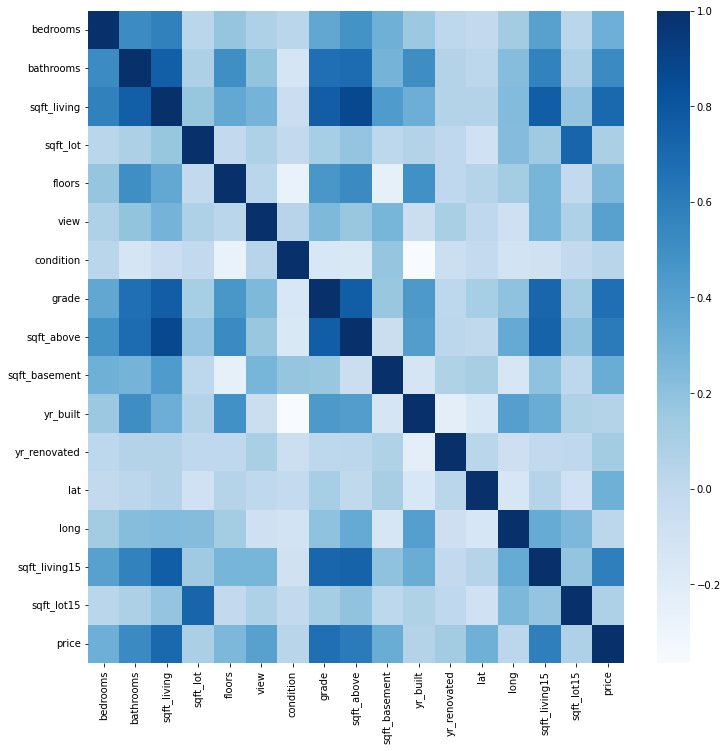

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap='Blues')

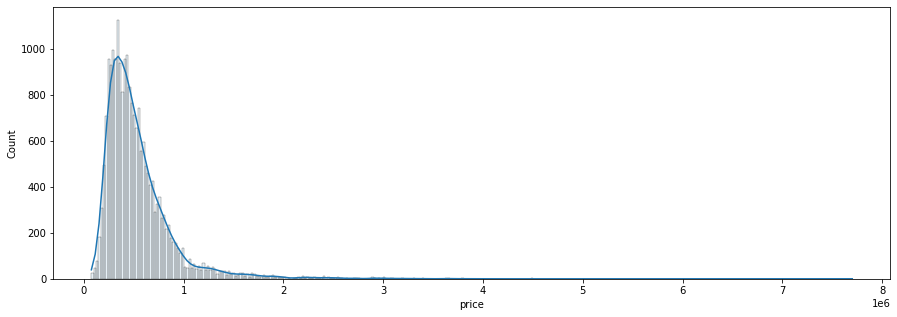

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='price'>

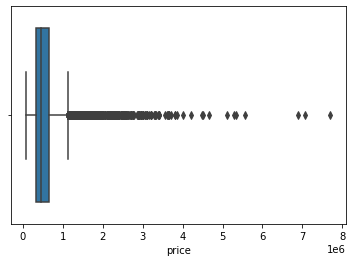

In [10]:
sns.boxplot(data=df, x='price')

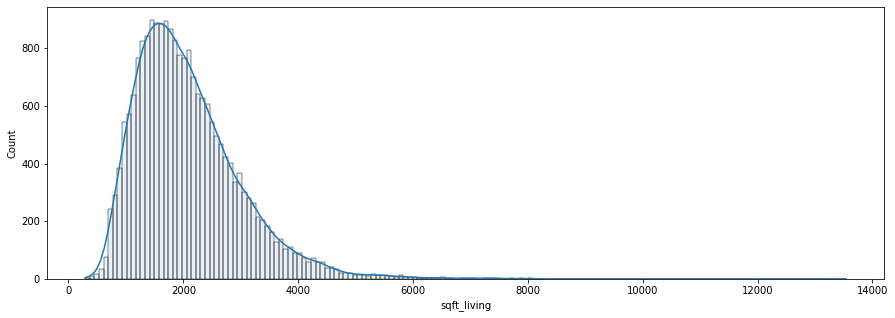

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

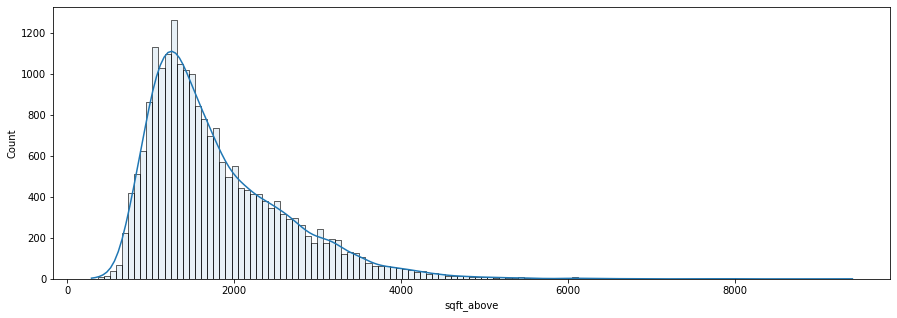

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_above', ax=ax, kde=True, alpha=0.1);

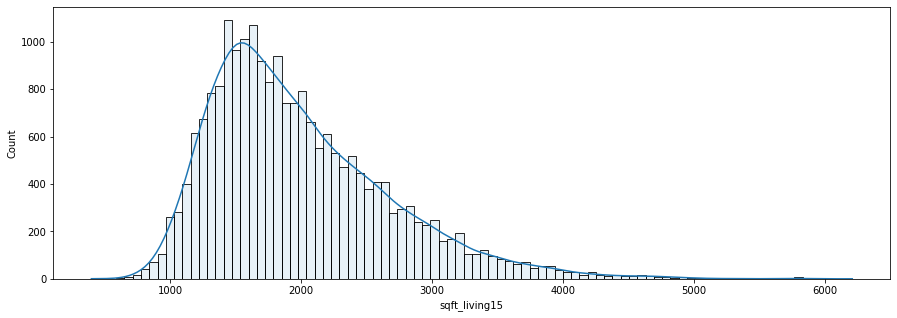

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

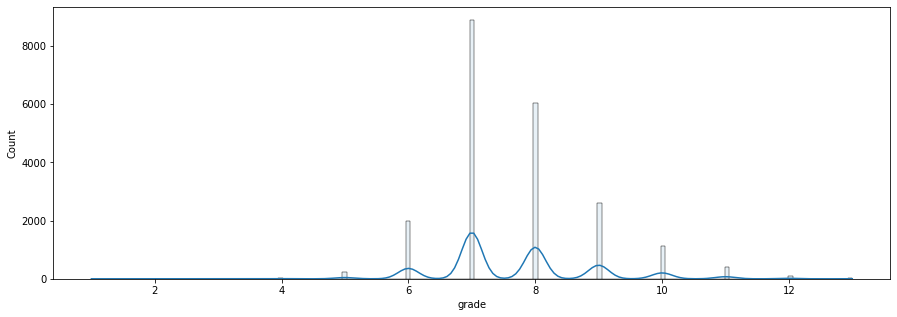

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='grade', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

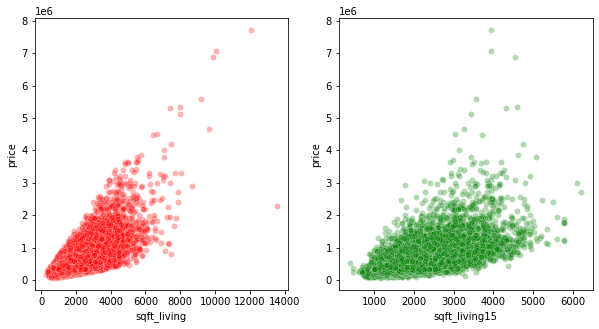

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

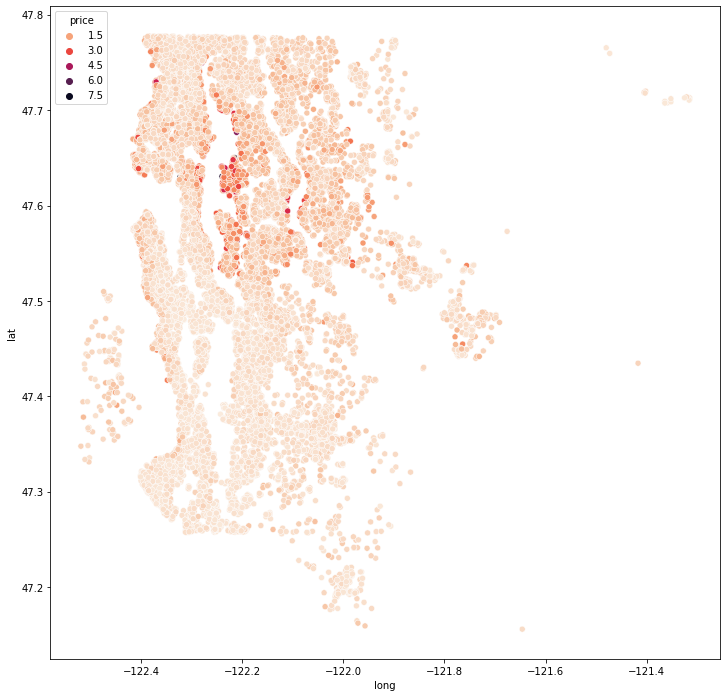

In [16]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

### Should we remove outliers?
For housing prices, a house could have been sold for a value less than what it worths. Or the house could've been sold more than what it worths. According to the red graph, some house with 13.5k sqft_living has been sold for about 2m dollars but some other house with about 12k sqft_living has been sold for about 7.5m dollars. This case could be seen as an outlier but there are other factors that have impact on the price.

In [17]:
df[df['sqft_living'] > 12000].T

id               6762700020    1225069038
bedrooms       6.000000e+00  7.000000e+00
bathrooms      8.000000e+00  8.000000e+00
sqft_living    1.205000e+04  1.354000e+04
sqft_lot       2.760000e+04  3.077520e+05
floors         2.500000e+00  3.000000e+00
view           3.000000e+00  4.000000e+00
condition      4.000000e+00  3.000000e+00
grade          1.300000e+01  1.200000e+01
sqft_above     8.570000e+03  9.410000e+03
sqft_basement  3.480000e+03  4.130000e+03
yr_built       1.910000e+03  1.999000e+03
yr_renovated   1.987000e+03  0.000000e+00
lat            4.762980e+01  4.766750e+01
long          -1.223230e+02 -1.219860e+02
sqft_living15  3.940000e+03  4.850000e+03
sqft_lot15     8.800000e+03  2.178000e+05
price          7.700000e+06  2.280000e+06

Two houses are somewhat the same and in the same area according to their lat and long. <br>
- More expensive one is older than the new one
- More expensive one's grade is greater than the other by 1 values
- sqft_lot15 is very large compared to the other one
- In 1987, the expensive house has been renovated but the other one hasn't been renovated
<br>
Other than these, the other house is better in every aspect. So why it is less expensive or not at all expensive? <br>
I'd say the first one is expensive because it is near the lake.

In [18]:
def remove_outliers(df, columns='all'):
    columns = df.columns if columns == 'all' else columns
    for c in columns:
        df = remove_columns_outlier(df, c)
    return df

def remove_columns_outlier(df, column):
    column = df[column]
    column_norm = (column - np.mean(column)) / np.std(column)
    column_norm = column_norm[~((column_norm >= 3) | (column_norm <= -3))]
    return df.loc[df.index[df.index.value_counts() == 1]]

def remove_outliers_per(df, column, per_column):
    fraction = column / per_column
    frac_norm = (fraction - np.mean(fraction)) / np.std(fraction)
    frac_norm = frac_norm[~((frac_norm >= 3) | (frac_norm <= -3))]
    return df.loc[list(frac_norm.index)]

def percentage_from_right(df, column, from_value):
    per = df[df[column] > from_value].size / df.size
    per = per * 100
    return per

def percentage_from_left(df, column, from_value):
    per = df[df[column] < from_value].size / df.size
    per = per * 100
    return per
    
def drop_tail_right(df, column, from_value, max_percentage=5):
    per = percentage_from_right(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] < from_value]

def drop_tail_left(df, column, from_value, max_percentage=5):
    per = percentage_from_left(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] > from_value]


def remove_outliers_IQR(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    res = drop_tail_right(df, column, q3 + 1.5 * IQR, 100)
    res = drop_tail_left(res, column, q1 - 1.5 * IQR, 100)
    per = percentage_from_right(df, column, q3 + 1.5 * IQR) + percentage_from_left(df, column, q1 - 1.5 * IQR)
    print(f'dropping {per:.2f}% data')
    return res

In [19]:
#df = remove_outliers(df, ['price'])
#df = remove_outliers_per(df, df['price'], df['sqft_living'])
#df = remove_outliers_per(df, df['price'], df['sqft_above'])
#df = remove_outliers_per(df, df['price'], df['sqft_living15'])

#df = drop_tail_right(df, 'price', 969000, 9)
#df = drop_tail_right(df, 'sqft_living', 3850, 3)
#df = drop_tail_right(df, 'sqft_living15', 3500, 3)
#df = drop_tail_left(df, 'grade', 5, 5)
#df = drop_tail_right(df, 'grade', 11, 5)

df = remove_outliers_IQR(df, 'price')
#df = remove_outliers_IQR(df, 'sqft_living')
#df = df.drop('sqft_above', axis=1)

dropping 5.31% data


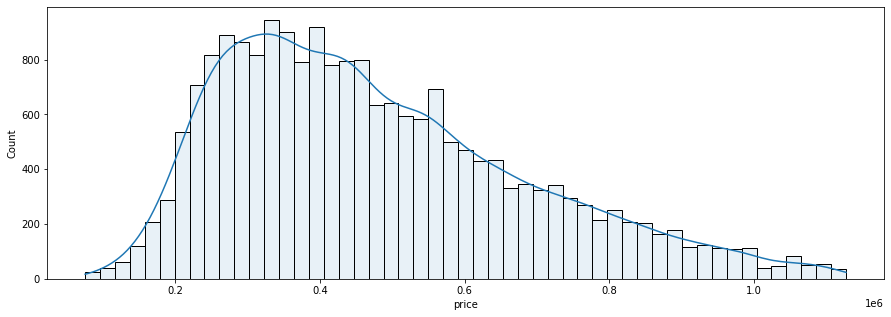

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

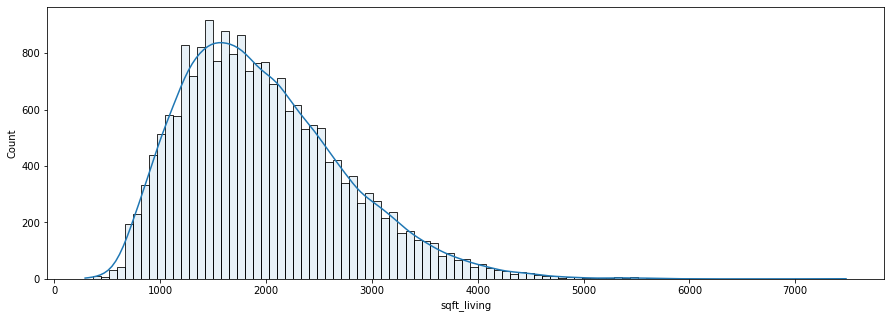

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

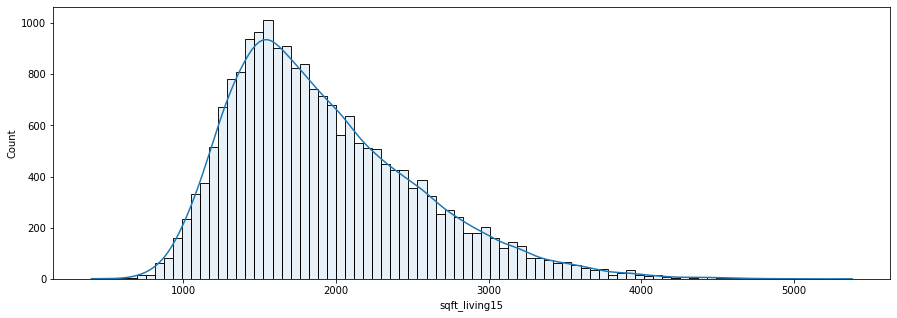

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

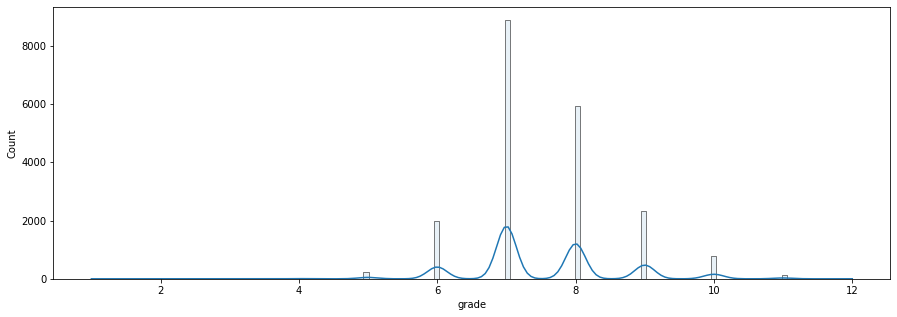

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='grade', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

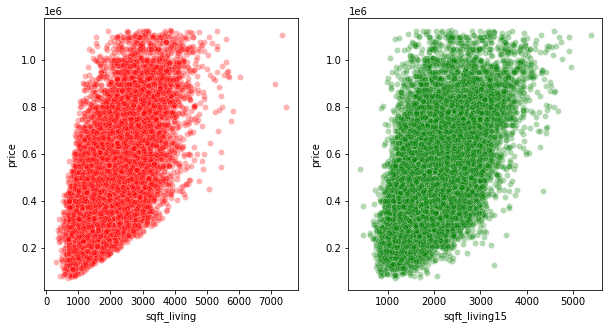

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

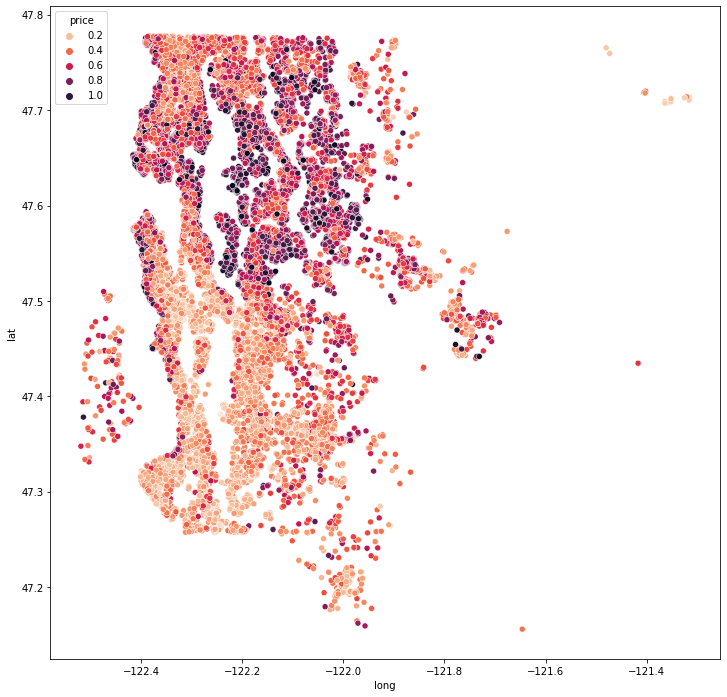

In [25]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

As it seems some regions here, have expensive houses, So we'll try to cluster each region.<br>
We'll use "lat" and "long" and "price" to cluster each using K_mean clustering algorithm.

In [26]:
selected = df[['lat', 'long', 'price']]
ids = selected.index.values
selected = selected.values
selected.shape

(20297, 3)

In [27]:
centeroids, idx = k_mean_optimization(selected, 10, 50, 20)

Iteration 1/20
Distortion: 770250941.6916865
Iteration 2/20
Distortion: 692185831.1403211
Iteration 3/20
Distortion: 702190796.695187
Iteration 4/20
Distortion: 784074351.9633671
Iteration 5/20
Distortion: 691620381.6132888
Iteration 6/20
Distortion: 717553048.9233866
Iteration 7/20
Distortion: 715581725.1832263
Iteration 8/20
Distortion: 709932706.1772183
Iteration 9/20
Distortion: 813795923.5721709
Iteration 10/20
Distortion: 717553048.9233866
Iteration 11/20
Distortion: 771022583.6387728
Iteration 12/20
Distortion: 709932706.1772183
Iteration 13/20
Distortion: 717553048.9233866
Iteration 14/20
Distortion: 793504163.7782413
Iteration 15/20
Distortion: 701790802.03629
Iteration 16/20
Distortion: 691451239.9007537
Iteration 17/20
Distortion: 696396359.1900002
Iteration 18/20
Distortion: 774420608.0948484
Iteration 19/20
Distortion: 715581725.1832263
Iteration 20/20
Distortion: 767120406.2141123

Distortion 691451239.9007537 is chosen!


In [28]:
selected = np.c_[ids, selected, idx]
selected = pd.DataFrame(selected, columns=['id', 'lat', 'long', 'price', 'cluster'])
selected

id      lat     long     price  cluster
0      7.129301e+09  47.5112 -122.257  221900.0      1.0
1      6.414100e+09  47.7210 -122.319  538000.0      5.0
2      5.631500e+09  47.7379 -122.233  180000.0      1.0
3      2.487201e+09  47.5208 -122.393  604000.0      5.0
4      1.954401e+09  47.6168 -122.045  510000.0      4.0
...             ...      ...      ...       ...      ...
20292  2.630000e+08  47.6993 -122.346  360000.0      2.0
20293  6.600060e+09  47.5107 -122.362  400000.0      8.0
20294  1.523300e+09  47.5944 -122.299  402101.0      8.0
20295  2.913101e+08  47.5345 -122.069  400000.0      8.0
20296  1.523300e+09  47.5941 -122.299  325000.0      2.0

[20297 rows x 5 columns]

In [29]:
selected.set_index('id', inplace=True)
selected

lat     long     price  cluster
id                                               
7.129301e+09  47.5112 -122.257  221900.0      1.0
6.414100e+09  47.7210 -122.319  538000.0      5.0
5.631500e+09  47.7379 -122.233  180000.0      1.0
2.487201e+09  47.5208 -122.393  604000.0      5.0
1.954401e+09  47.6168 -122.045  510000.0      4.0
...               ...      ...       ...      ...
2.630000e+08  47.6993 -122.346  360000.0      2.0
6.600060e+09  47.5107 -122.362  400000.0      8.0
1.523300e+09  47.5944 -122.299  402101.0      8.0
2.913101e+08  47.5345 -122.069  400000.0      8.0
1.523300e+09  47.5941 -122.299  325000.0      2.0

[20297 rows x 4 columns]

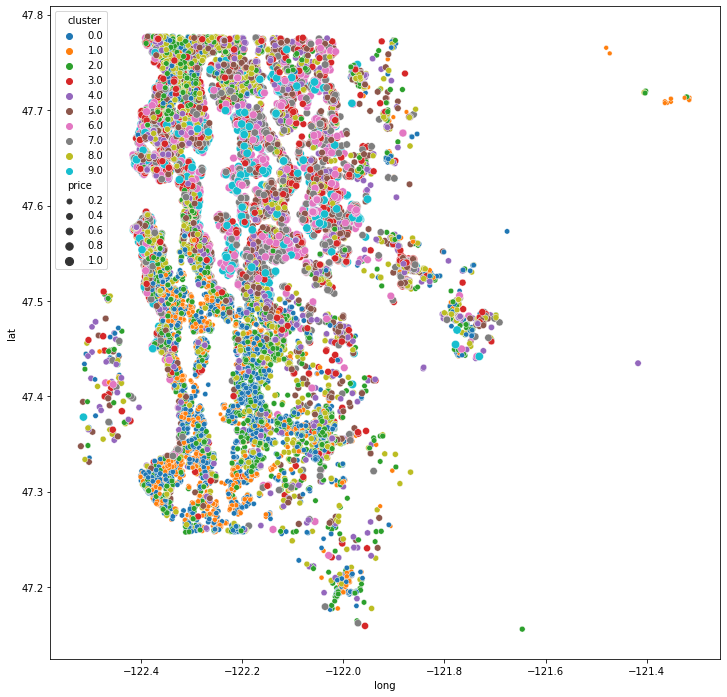

In [30]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=selected, x='long', y='lat', hue='cluster', palette='tab10', size='price');

In [31]:
clusters = pd.get_dummies(data=selected.cluster, drop_first=True, prefix='cluster')
df = pd.concat([df, clusters], axis=1)

In [32]:
df = df.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'], axis=1)

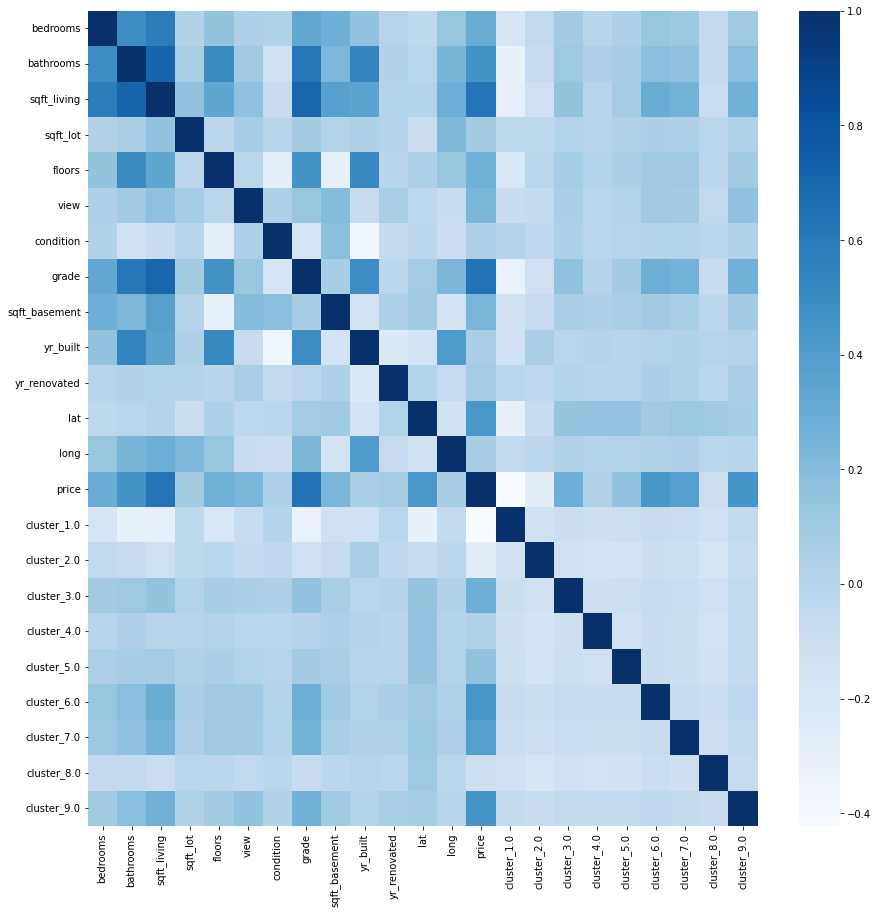

In [33]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cmap='Blues');

In [34]:
df.describe().T

count           mean            std         min          25%  \
bedrooms       20297.0       3.330246       0.911846      0.0000       3.0000   
bathrooms      20297.0       2.054084       0.711399      0.0000       1.5000   
sqft_living    20297.0    1978.235158     775.491728    290.0000    1400.0000   
sqft_lot       20297.0   14646.335173   40247.208902    520.0000    5000.0000   
floors         20297.0       1.477854       0.537484      1.0000       1.0000   
view           20297.0       0.173622       0.642417      0.0000       0.0000   
condition      20297.0       3.407499       0.646790      1.0000       3.0000   
grade          20297.0       7.535498       1.038258      1.0000       7.0000   
sqft_basement  20297.0     267.498596     409.367450      0.0000       0.0000   
yr_built       20297.0    1970.910874      29.168739   1900.0000    1952.0000   
yr_renovated   20297.0      74.916539     379.343170      0.0000       0.0000   
lat            20297.0      47.556983       0.141081     47.1559      47.4604   
long           20297.0    -122.213026       0.142481   -122.5190    -122.3300   
price          20297.0  477262.096369  208498.449648  75000.0000  315000.0000   
cluster_1.0    20297.0       0.089422       0.285359      0.0000       0.0000   
cluster_2.0    20297.0       0.156575       0.363408      0.0000       0.0000   
cluster_3.0    20297.0       0.088732       0.284364      0.0000       0.0000   
cluster_4.0    20297.0       0.115042       0.319080      0.0000       0.0000   
cluster_5.0    20297.0       0.108883       0.311500      0.0000       0.0000   
cluster_6.0    20297.0       0.047889       0.213536      0.0000       0.0000   
cluster_7.0    20297.0       0.070749       0.256412      0.0000       0.0000   
cluster_8.0    20297.0       0.142189       0.349252      0.0000       0.0000   
cluster_9.0    20297.0       0.027640       0.163942      0.0000       0.0000   

                       50%          75%           max  
bedrooms            3.0000       4.0000  3.300000e+01  
bathrooms           2.0000       2.5000  7.500000e+00  
sqft_living      1860.0000    2440.0000  7.480000e+03  
sqft_lot         7500.0000   10321.0000  1.651359e+06  
floors              1.0000       2.0000  3.500000e+00  
view                0.0000       0.0000  4.000000e+00  
condition           3.0000       4.0000  5.000000e+00  
grade               7.0000       8.0000  1.200000e+01  
sqft_basement       0.0000     510.0000  2.720000e+03  
yr_built         1975.0000    1996.0000  2.015000e+03  
yr_renovated        0.0000       0.0000  2.015000e+03  
lat                47.5671      47.6798  4.777760e+01  
long             -122.2310    -122.1220 -1.213150e+02  
price          437850.0000  601000.0000  1.127500e+06  
cluster_1.0         0.0000       0.0000  1.000000e+00  
cluster_2.0         0.0000       0.0000  1.000000e+00  
cluster_3.0         0.0000       0.0000  1.000000e+00  
cluster_4.0         0.0000       0.0000  1.000000e+00  
cluster_5.0         0.0000       0.0000  1.000000e+00  
cluster_6.0         0.0000       0.0000  1.000000e+00  
cluster_7.0         0.0000       0.0000  1.000000e+00  
cluster_8.0         0.0000       0.0000  1.000000e+00  
cluster_9.0         0.0000       0.0000  1.000000e+00

## Getting Data ready for trainning

In [35]:
X_train = df.drop(['price'], axis=1).values
y_train = df['price'].values

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly = poly.fit(X_train)
X_train = poly.transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=123)
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

In [36]:
print(f'X_train shape is {X_train.shape} and y_train shape is {y_train.shape}')
print(f'y_cv shape is {X_cv.shape} and y_cv shape is {y_cv.shape}')
print(f'X_test shape is {X_test.shape} and y_test shape is {y_test.shape}')

X_train shape is (16237, 275) and y_train shape is (16237,)
y_cv shape is (2030, 275) and y_cv shape is (2030,)
X_test shape is (2030, 275) and y_test shape is (2030,)


### Normalize the data

In [37]:
norm = Normalization()
norm.adapt(X_train)
Xn_train = norm(X_train)
Xn_cv = norm(X_cv)
Xn_test = norm(X_test)

## Training

In [38]:
model = SGDRegressor(max_iter=100000, verbose=True, eta0=0.0001, tol=1e-5)
model = model.fit(Xn_train, y_train)

-- Epoch 1
Norm: 43832.79, NNZs: 239, Bias: 83311.130920, T: 16237, Avg. loss: 96887562021.013977
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 49555.21, NNZs: 239, Bias: 131666.456764, T: 32474, Avg. loss: 70216372986.461639
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 53379.56, NNZs: 239, Bias: 169157.131569, T: 48711, Avg. loss: 54978589848.840645
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 55648.53, NNZs: 239, Bias: 199994.988113, T: 64948, Avg. loss: 44197482242.906250
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 58281.06, NNZs: 239, Bias: 226128.156963, T: 81185, Avg. loss: 36121288435.108154
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 60093.68, NNZs: 239, Bias: 248693.034591, T: 97422, Avg. loss: 29872764436.363140
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 61750.75, NNZs: 239, Bias: 268427.540074, T: 113659, Avg. loss: 24931290902.245270
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 63189.74, NNZs: 239, Bias: 285852.314969, T: 

Norm: 86007.43, NNZs: 239, Bias: 473424.193287, T: 1169064, Avg. loss: 388565715.003325
Total training time: 0.82 seconds.
-- Epoch 73
Norm: 86088.40, NNZs: 239, Bias: 473624.542601, T: 1185301, Avg. loss: 387326016.655631
Total training time: 0.83 seconds.
-- Epoch 74
Norm: 86166.62, NNZs: 239, Bias: 473814.751692, T: 1201538, Avg. loss: 386175478.992213
Total training time: 0.84 seconds.
-- Epoch 75
Norm: 86232.77, NNZs: 239, Bias: 473995.360580, T: 1217775, Avg. loss: 385126620.967902
Total training time: 0.85 seconds.
-- Epoch 76
Norm: 86302.35, NNZs: 239, Bias: 474166.569083, T: 1234012, Avg. loss: 384155128.870905
Total training time: 0.87 seconds.
-- Epoch 77
Norm: 86360.14, NNZs: 239, Bias: 474328.946163, T: 1250249, Avg. loss: 383253093.107311
Total training time: 0.88 seconds.
-- Epoch 78
Norm: 86433.14, NNZs: 239, Bias: 474483.284622, T: 1266486, Avg. loss: 382409966.464080
Total training time: 0.89 seconds.
-- Epoch 79
Norm: 86493.98, NNZs: 239, Bias: 474629.835786, T: 1282

Norm: 88698.21, NNZs: 239, Bias: 477417.125059, T: 2321891, Avg. loss: 365775864.045572
Total training time: 1.64 seconds.
-- Epoch 144
Norm: 88723.47, NNZs: 239, Bias: 477424.146948, T: 2338128, Avg. loss: 365651090.445580
Total training time: 1.65 seconds.
-- Epoch 145
Norm: 88745.40, NNZs: 239, Bias: 477430.852845, T: 2354365, Avg. loss: 365540041.665685
Total training time: 1.66 seconds.
-- Epoch 146
Norm: 88761.74, NNZs: 239, Bias: 477437.387939, T: 2370602, Avg. loss: 365435397.378110
Total training time: 1.67 seconds.
-- Epoch 147
Norm: 88777.34, NNZs: 239, Bias: 477443.554252, T: 2386839, Avg. loss: 365315383.495020
Total training time: 1.69 seconds.
-- Epoch 148
Norm: 88795.19, NNZs: 239, Bias: 477449.426488, T: 2403076, Avg. loss: 365202063.114282
Total training time: 1.70 seconds.
-- Epoch 149
Norm: 88817.56, NNZs: 239, Bias: 477455.153870, T: 2419313, Avg. loss: 365087233.204887
Total training time: 1.71 seconds.
-- Epoch 150
Norm: 88834.10, NNZs: 239, Bias: 477460.462754, 

Norm: 89848.57, NNZs: 239, Bias: 477578.996736, T: 3507192, Avg. loss: 359133683.169023
Total training time: 2.47 seconds.
-- Epoch 217
Norm: 89861.58, NNZs: 239, Bias: 477579.306988, T: 3523429, Avg. loss: 359066218.680118
Total training time: 2.48 seconds.
-- Epoch 218
Norm: 89869.51, NNZs: 239, Bias: 477579.612648, T: 3539666, Avg. loss: 358982077.072706
Total training time: 2.49 seconds.
-- Epoch 219
Norm: 89885.95, NNZs: 239, Bias: 477580.123000, T: 3555903, Avg. loss: 358914619.582266
Total training time: 2.50 seconds.
-- Epoch 220
Norm: 89903.97, NNZs: 239, Bias: 477580.442234, T: 3572140, Avg. loss: 358845648.651865
Total training time: 2.51 seconds.
-- Epoch 221
Norm: 89908.67, NNZs: 239, Bias: 477580.631536, T: 3588377, Avg. loss: 358768300.052106
Total training time: 2.53 seconds.
-- Epoch 222
Norm: 89925.28, NNZs: 239, Bias: 477580.825757, T: 3604614, Avg. loss: 358704949.162124
Total training time: 2.54 seconds.
-- Epoch 223
Norm: 89940.91, NNZs: 239, Bias: 477581.154805, 

Norm: 90723.05, NNZs: 239, Bias: 477587.584644, T: 4676256, Avg. loss: 354717347.819251
Total training time: 3.28 seconds.
-- Epoch 289
Norm: 90731.26, NNZs: 239, Bias: 477587.595182, T: 4692493, Avg. loss: 354660278.124110
Total training time: 3.29 seconds.
-- Epoch 290
Norm: 90744.87, NNZs: 239, Bias: 477587.713978, T: 4708730, Avg. loss: 354611812.202631
Total training time: 3.30 seconds.
-- Epoch 291
Norm: 90756.27, NNZs: 239, Bias: 477587.777234, T: 4724967, Avg. loss: 354557281.103867
Total training time: 3.31 seconds.
-- Epoch 292
Norm: 90762.95, NNZs: 239, Bias: 477587.829058, T: 4741204, Avg. loss: 354501514.010849
Total training time: 3.32 seconds.
-- Epoch 293
Norm: 90773.42, NNZs: 239, Bias: 477587.774869, T: 4757441, Avg. loss: 354457129.219630
Total training time: 3.34 seconds.
-- Epoch 294
Norm: 90788.57, NNZs: 239, Bias: 477587.901458, T: 4773678, Avg. loss: 354401297.654578
Total training time: 3.35 seconds.
-- Epoch 295
Norm: 90797.24, NNZs: 239, Bias: 477587.991926, 

Norm: 91496.99, NNZs: 239, Bias: 477587.977052, T: 5845320, Avg. loss: 351430883.780919
Total training time: 4.09 seconds.
-- Epoch 361
Norm: 91508.70, NNZs: 239, Bias: 477588.097634, T: 5861557, Avg. loss: 351387065.078048
Total training time: 4.10 seconds.
-- Epoch 362
Norm: 91515.14, NNZs: 239, Bias: 477588.135201, T: 5877794, Avg. loss: 351347699.668264
Total training time: 4.11 seconds.
-- Epoch 363
Norm: 91529.13, NNZs: 239, Bias: 477587.984284, T: 5894031, Avg. loss: 351303926.443456
Total training time: 4.13 seconds.
-- Epoch 364
Norm: 91537.05, NNZs: 239, Bias: 477587.970356, T: 5910268, Avg. loss: 351267983.325753
Total training time: 4.14 seconds.
-- Epoch 365
Norm: 91548.94, NNZs: 239, Bias: 477587.935106, T: 5926505, Avg. loss: 351233971.866808
Total training time: 4.15 seconds.
-- Epoch 366
Norm: 91557.58, NNZs: 239, Bias: 477587.918233, T: 5942742, Avg. loss: 351190950.149226
Total training time: 4.16 seconds.
-- Epoch 367
Norm: 91565.50, NNZs: 239, Bias: 477588.031662, 

Norm: 92224.56, NNZs: 239, Bias: 477588.346167, T: 7046858, Avg. loss: 348796651.442330
Total training time: 4.92 seconds.
-- Epoch 435
Norm: 92233.26, NNZs: 239, Bias: 477588.370252, T: 7063095, Avg. loss: 348764608.739184
Total training time: 4.93 seconds.
-- Epoch 436
Norm: 92242.71, NNZs: 239, Bias: 477588.415206, T: 7079332, Avg. loss: 348732556.171054
Total training time: 4.95 seconds.
-- Epoch 437
Norm: 92258.32, NNZs: 239, Bias: 477588.488816, T: 7095569, Avg. loss: 348692097.763428
Total training time: 4.96 seconds.
-- Epoch 438
Norm: 92261.06, NNZs: 239, Bias: 477588.405920, T: 7111806, Avg. loss: 348670306.625968
Total training time: 4.97 seconds.
-- Epoch 439
Norm: 92269.50, NNZs: 239, Bias: 477588.358622, T: 7128043, Avg. loss: 348634798.885684
Total training time: 4.98 seconds.
-- Epoch 440
Norm: 92281.26, NNZs: 239, Bias: 477588.304076, T: 7144280, Avg. loss: 348608238.278037
Total training time: 4.99 seconds.
-- Epoch 441
Norm: 92288.58, NNZs: 239, Bias: 477588.412500, 

Norm: 92892.86, NNZs: 239, Bias: 477588.214897, T: 8232159, Avg. loss: 346695599.261611
Total training time: 5.74 seconds.
-- Epoch 508
Norm: 92895.12, NNZs: 239, Bias: 477588.129675, T: 8248396, Avg. loss: 346667468.038810
Total training time: 5.75 seconds.
-- Epoch 509
Norm: 92902.23, NNZs: 239, Bias: 477588.069106, T: 8264633, Avg. loss: 346646813.671320
Total training time: 5.77 seconds.
-- Epoch 510
Norm: 92911.62, NNZs: 239, Bias: 477587.953118, T: 8280870, Avg. loss: 346624955.000225
Total training time: 5.78 seconds.
-- Epoch 511
Norm: 92920.19, NNZs: 239, Bias: 477587.891985, T: 8297107, Avg. loss: 346596087.251825
Total training time: 5.79 seconds.
-- Epoch 512
Norm: 92928.18, NNZs: 239, Bias: 477587.903291, T: 8313344, Avg. loss: 346571950.267518
Total training time: 5.80 seconds.
-- Epoch 513
Norm: 92933.11, NNZs: 239, Bias: 477587.881287, T: 8329581, Avg. loss: 346537461.519740
Total training time: 5.81 seconds.
-- Epoch 514
Norm: 92946.08, NNZs: 239, Bias: 477588.057453, 

Norm: 93514.86, NNZs: 239, Bias: 477588.048673, T: 9433697, Avg. loss: 344932694.780093
Total training time: 6.57 seconds.
-- Epoch 582
Norm: 93523.99, NNZs: 239, Bias: 477588.042722, T: 9449934, Avg. loss: 344906696.165914
Total training time: 6.58 seconds.
-- Epoch 583
Norm: 93535.56, NNZs: 239, Bias: 477588.116067, T: 9466171, Avg. loss: 344879392.579864
Total training time: 6.59 seconds.
-- Epoch 584
Norm: 93538.51, NNZs: 239, Bias: 477588.129762, T: 9482408, Avg. loss: 344856709.549027
Total training time: 6.60 seconds.
-- Epoch 585
Norm: 93549.94, NNZs: 239, Bias: 477588.203843, T: 9498645, Avg. loss: 344839683.606862
Total training time: 6.61 seconds.
-- Epoch 586
Norm: 93558.12, NNZs: 239, Bias: 477588.219495, T: 9514882, Avg. loss: 344825032.132484
Total training time: 6.63 seconds.
-- Epoch 587
Norm: 93566.79, NNZs: 239, Bias: 477588.234335, T: 9531119, Avg. loss: 344799568.110275
Total training time: 6.64 seconds.
-- Epoch 588
Norm: 93572.09, NNZs: 239, Bias: 477588.260635, 

Norm: 94094.78, NNZs: 239, Bias: 477588.122489, T: 10618998, Avg. loss: 343450382.076992
Total training time: 7.40 seconds.
-- Epoch 655
Norm: 94101.66, NNZs: 239, Bias: 477588.109153, T: 10635235, Avg. loss: 343433725.927552
Total training time: 7.41 seconds.
-- Epoch 656
Norm: 94110.95, NNZs: 239, Bias: 477588.097118, T: 10651472, Avg. loss: 343406165.890028
Total training time: 7.42 seconds.
-- Epoch 657
Norm: 94116.33, NNZs: 239, Bias: 477588.093479, T: 10667709, Avg. loss: 343390152.072894
Total training time: 7.43 seconds.
-- Epoch 658
Norm: 94120.57, NNZs: 239, Bias: 477588.054262, T: 10683946, Avg. loss: 343371433.923789
Total training time: 7.44 seconds.
-- Epoch 659
Norm: 94129.47, NNZs: 239, Bias: 477588.072761, T: 10700183, Avg. loss: 343357379.567686
Total training time: 7.45 seconds.
-- Epoch 660
Norm: 94135.64, NNZs: 239, Bias: 477588.058892, T: 10716420, Avg. loss: 343331281.196768
Total training time: 7.46 seconds.
-- Epoch 661
Norm: 94145.85, NNZs: 239, Bias: 477588.0

Norm: 94651.36, NNZs: 239, Bias: 477588.363769, T: 11836773, Avg. loss: 342134126.535454
Total training time: 8.23 seconds.
-- Epoch 730
Norm: 94665.54, NNZs: 239, Bias: 477588.361391, T: 11853010, Avg. loss: 342109675.149874
Total training time: 8.24 seconds.
-- Epoch 731
Norm: 94669.43, NNZs: 239, Bias: 477588.355706, T: 11869247, Avg. loss: 342101568.413501
Total training time: 8.25 seconds.
-- Epoch 732
Norm: 94675.23, NNZs: 239, Bias: 477588.350416, T: 11885484, Avg. loss: 342086978.627871
Total training time: 8.26 seconds.
-- Epoch 733
Norm: 94681.52, NNZs: 239, Bias: 477588.318465, T: 11901721, Avg. loss: 342073698.301184
Total training time: 8.28 seconds.
-- Epoch 734
Norm: 94690.97, NNZs: 239, Bias: 477588.340269, T: 11917958, Avg. loss: 342059092.602242
Total training time: 8.29 seconds.
-- Epoch 735
Norm: 94698.85, NNZs: 239, Bias: 477588.383300, T: 11934195, Avg. loss: 342043142.727433
Total training time: 8.30 seconds.
-- Epoch 736
Norm: 94702.50, NNZs: 239, Bias: 477588.3

Norm: 95169.86, NNZs: 239, Bias: 477588.605841, T: 13005837, Avg. loss: 341023481.178993
Total training time: 9.04 seconds.
-- Epoch 802
Norm: 95173.22, NNZs: 239, Bias: 477588.564001, T: 13022074, Avg. loss: 341024646.788093
Total training time: 9.06 seconds.
-- Epoch 803
Norm: 95178.58, NNZs: 239, Bias: 477588.514741, T: 13038311, Avg. loss: 341005177.658169
Total training time: 9.07 seconds.
-- Epoch 804
Norm: 95188.83, NNZs: 239, Bias: 477588.552565, T: 13054548, Avg. loss: 340981715.777127
Total training time: 9.08 seconds.
-- Epoch 805
Norm: 95192.76, NNZs: 239, Bias: 477588.483431, T: 13070785, Avg. loss: 340980842.135736
Total training time: 9.09 seconds.
-- Epoch 806
Norm: 95200.31, NNZs: 239, Bias: 477588.500943, T: 13087022, Avg. loss: 340962479.174019
Total training time: 9.10 seconds.
-- Epoch 807
Norm: 95208.55, NNZs: 239, Bias: 477588.408807, T: 13103259, Avg. loss: 340946509.794334
Total training time: 9.11 seconds.
-- Epoch 808
Norm: 95211.32, NNZs: 239, Bias: 477588.4

Norm: 95647.25, NNZs: 239, Bias: 477588.508927, T: 14174901, Avg. loss: 340056681.064141
Total training time: 9.86 seconds.
-- Epoch 874
Norm: 95650.61, NNZs: 239, Bias: 477588.536535, T: 14191138, Avg. loss: 340040548.773878
Total training time: 9.88 seconds.
-- Epoch 875
Norm: 95656.24, NNZs: 239, Bias: 477588.492228, T: 14207375, Avg. loss: 340029654.472317
Total training time: 9.89 seconds.
-- Epoch 876
Norm: 95659.35, NNZs: 239, Bias: 477588.436449, T: 14223612, Avg. loss: 340003173.035259
Total training time: 9.90 seconds.
-- Epoch 877
Norm: 95671.35, NNZs: 239, Bias: 477588.431793, T: 14239849, Avg. loss: 340005066.792452
Total training time: 9.91 seconds.
-- Epoch 878
Norm: 95677.59, NNZs: 239, Bias: 477588.515891, T: 14256086, Avg. loss: 339983355.175987
Total training time: 9.92 seconds.
-- Epoch 879
Norm: 95681.75, NNZs: 239, Bias: 477588.432536, T: 14272323, Avg. loss: 339976072.438522
Total training time: 9.93 seconds.
-- Epoch 880
Norm: 95689.74, NNZs: 239, Bias: 477588.3

Norm: 96107.92, NNZs: 239, Bias: 477588.465275, T: 15343965, Avg. loss: 339176939.844203
Total training time: 10.69 seconds.
-- Epoch 946
Norm: 96110.32, NNZs: 239, Bias: 477588.439471, T: 15360202, Avg. loss: 339155870.637002
Total training time: 10.70 seconds.
-- Epoch 947
Norm: 96115.85, NNZs: 239, Bias: 477588.355616, T: 15376439, Avg. loss: 339146049.186000
Total training time: 10.71 seconds.
-- Epoch 948
Norm: 96125.46, NNZs: 239, Bias: 477588.362185, T: 15392676, Avg. loss: 339141727.483072
Total training time: 10.72 seconds.
-- Epoch 949
Norm: 96134.12, NNZs: 239, Bias: 477588.385462, T: 15408913, Avg. loss: 339127538.887956
Total training time: 10.73 seconds.
-- Epoch 950
Norm: 96142.08, NNZs: 239, Bias: 477588.381200, T: 15425150, Avg. loss: 339112564.637492
Total training time: 10.74 seconds.
-- Epoch 951
Norm: 96141.78, NNZs: 239, Bias: 477588.299990, T: 15441387, Avg. loss: 339097926.176445
Total training time: 10.75 seconds.
-- Epoch 952
Norm: 96151.10, NNZs: 239, Bias: 4

Norm: 96562.63, NNZs: 239, Bias: 477588.182373, T: 16561740, Avg. loss: 338353091.010780
Total training time: 11.52 seconds.
-- Epoch 1021
Norm: 96566.62, NNZs: 239, Bias: 477588.128035, T: 16577977, Avg. loss: 338342122.381538
Total training time: 11.54 seconds.
-- Epoch 1022
Norm: 96576.45, NNZs: 239, Bias: 477588.087809, T: 16594214, Avg. loss: 338325521.912959
Total training time: 11.55 seconds.
-- Epoch 1023
Norm: 96579.83, NNZs: 239, Bias: 477588.158084, T: 16610451, Avg. loss: 338319766.506705
Total training time: 11.56 seconds.
-- Epoch 1024
Norm: 96588.23, NNZs: 239, Bias: 477588.126688, T: 16626688, Avg. loss: 338308883.733459
Total training time: 11.57 seconds.
-- Epoch 1025
Norm: 96594.89, NNZs: 239, Bias: 477588.116854, T: 16642925, Avg. loss: 338296504.168503
Total training time: 11.58 seconds.
-- Epoch 1026
Norm: 96600.28, NNZs: 239, Bias: 477588.063967, T: 16659162, Avg. loss: 338287959.758722
Total training time: 11.59 seconds.
-- Epoch 1027
Norm: 96605.76, NNZs: 239, 

Norm: 96994.64, NNZs: 239, Bias: 477588.174068, T: 17763278, Avg. loss: 337612925.507079
Total training time: 12.35 seconds.
-- Epoch 1095
Norm: 97002.65, NNZs: 239, Bias: 477588.141015, T: 17779515, Avg. loss: 337600804.649732
Total training time: 12.37 seconds.
-- Epoch 1096
Norm: 97003.33, NNZs: 239, Bias: 477588.180828, T: 17795752, Avg. loss: 337583777.597602
Total training time: 12.38 seconds.
-- Epoch 1097
Norm: 97010.01, NNZs: 239, Bias: 477588.184607, T: 17811989, Avg. loss: 337585553.874086
Total training time: 12.39 seconds.
-- Epoch 1098
Norm: 97013.00, NNZs: 239, Bias: 477588.110206, T: 17828226, Avg. loss: 337567607.325427
Total training time: 12.40 seconds.
-- Epoch 1099
Norm: 97020.19, NNZs: 239, Bias: 477588.101218, T: 17844463, Avg. loss: 337568584.531552
Total training time: 12.41 seconds.
-- Epoch 1100
Norm: 97027.20, NNZs: 239, Bias: 477588.170502, T: 17860700, Avg. loss: 337551280.207735
Total training time: 12.42 seconds.
-- Epoch 1101
Norm: 97030.45, NNZs: 239, 

Norm: 97414.90, NNZs: 239, Bias: 477588.128063, T: 18981053, Avg. loss: 336931294.433124
Total training time: 13.19 seconds.
-- Epoch 1170
Norm: 97415.95, NNZs: 239, Bias: 477588.080073, T: 18997290, Avg. loss: 336913750.941403
Total training time: 13.20 seconds.
-- Epoch 1171
Norm: 97425.85, NNZs: 239, Bias: 477588.086972, T: 19013527, Avg. loss: 336911179.037227
Total training time: 13.21 seconds.
-- Epoch 1172
Norm: 97429.61, NNZs: 239, Bias: 477588.100855, T: 19029764, Avg. loss: 336898812.252985
Total training time: 13.23 seconds.
-- Epoch 1173
Norm: 97431.92, NNZs: 239, Bias: 477588.140195, T: 19046001, Avg. loss: 336887759.871317
Total training time: 13.24 seconds.
-- Epoch 1174
Norm: 97438.01, NNZs: 239, Bias: 477588.144166, T: 19062238, Avg. loss: 336883289.185805
Total training time: 13.25 seconds.
-- Epoch 1175
Norm: 97447.07, NNZs: 239, Bias: 477588.066518, T: 19078475, Avg. loss: 336880262.818682
Total training time: 13.26 seconds.
-- Epoch 1176
Norm: 97453.56, NNZs: 239, 

Norm: 97814.81, NNZs: 239, Bias: 477588.118628, T: 20182591, Avg. loss: 336313946.257329
Total training time: 14.02 seconds.
-- Epoch 1244
Norm: 97819.23, NNZs: 239, Bias: 477588.206432, T: 20198828, Avg. loss: 336304839.398820
Total training time: 14.03 seconds.
-- Epoch 1245
Norm: 97824.76, NNZs: 239, Bias: 477588.237026, T: 20215065, Avg. loss: 336297427.186160
Total training time: 14.04 seconds.
-- Epoch 1246
Norm: 97831.17, NNZs: 239, Bias: 477588.293524, T: 20231302, Avg. loss: 336285128.247653
Total training time: 14.05 seconds.
-- Epoch 1247
Norm: 97837.84, NNZs: 239, Bias: 477588.278234, T: 20247539, Avg. loss: 336274623.910633
Total training time: 14.06 seconds.
-- Epoch 1248
Norm: 97841.02, NNZs: 239, Bias: 477588.291346, T: 20263776, Avg. loss: 336272855.504555
Total training time: 14.08 seconds.
-- Epoch 1249
Norm: 97845.80, NNZs: 239, Bias: 477588.314480, T: 20280013, Avg. loss: 336263505.936869
Total training time: 14.09 seconds.
-- Epoch 1250
Norm: 97851.08, NNZs: 239, 

Norm: 98184.28, NNZs: 239, Bias: 477588.140689, T: 21351655, Avg. loss: 335757955.028935
Total training time: 14.83 seconds.
-- Epoch 1316
Norm: 98192.63, NNZs: 239, Bias: 477588.125317, T: 21367892, Avg. loss: 335746854.312630
Total training time: 14.84 seconds.
-- Epoch 1317
Norm: 98196.50, NNZs: 239, Bias: 477588.113466, T: 21384129, Avg. loss: 335745102.871613
Total training time: 14.85 seconds.
-- Epoch 1318
Norm: 98202.06, NNZs: 239, Bias: 477588.089652, T: 21400366, Avg. loss: 335733470.838669
Total training time: 14.86 seconds.
-- Epoch 1319
Norm: 98206.69, NNZs: 239, Bias: 477588.066903, T: 21416603, Avg. loss: 335729459.570411
Total training time: 14.88 seconds.
-- Epoch 1320
Norm: 98214.33, NNZs: 239, Bias: 477588.094317, T: 21432840, Avg. loss: 335714620.747189
Total training time: 14.88 seconds.
-- Epoch 1321
Norm: 98216.19, NNZs: 239, Bias: 477588.005523, T: 21449077, Avg. loss: 335712818.762883
Total training time: 14.90 seconds.
-- Epoch 1322
Norm: 98221.65, NNZs: 239, 

Norm: 98564.79, NNZs: 239, Bias: 477588.236788, T: 22585667, Avg. loss: 335216029.652560
Total training time: 15.67 seconds.
-- Epoch 1392
Norm: 98569.18, NNZs: 239, Bias: 477588.158443, T: 22601904, Avg. loss: 335208641.849082
Total training time: 15.68 seconds.
-- Epoch 1393
Norm: 98572.82, NNZs: 239, Bias: 477588.182871, T: 22618141, Avg. loss: 335199411.490447
Total training time: 15.69 seconds.
-- Epoch 1394
Norm: 98578.50, NNZs: 239, Bias: 477588.161023, T: 22634378, Avg. loss: 335192114.989209
Total training time: 15.71 seconds.
-- Epoch 1395
Norm: 98583.45, NNZs: 239, Bias: 477588.179948, T: 22650615, Avg. loss: 335188895.234563
Total training time: 15.72 seconds.
-- Epoch 1396
Norm: 98590.61, NNZs: 239, Bias: 477588.250175, T: 22666852, Avg. loss: 335179416.818707
Total training time: 15.73 seconds.
-- Epoch 1397
Norm: 98595.45, NNZs: 239, Bias: 477588.243777, T: 22683089, Avg. loss: 335172849.099215
Total training time: 15.74 seconds.
-- Epoch 1398
Norm: 98598.45, NNZs: 239, 

Norm: 98919.83, NNZs: 239, Bias: 477588.298667, T: 23770968, Avg. loss: 334730205.230726
Total training time: 16.49 seconds.
-- Epoch 1465
Norm: 98925.50, NNZs: 239, Bias: 477588.275289, T: 23787205, Avg. loss: 334722378.195512
Total training time: 16.51 seconds.
-- Epoch 1466
Norm: 98930.95, NNZs: 239, Bias: 477588.281902, T: 23803442, Avg. loss: 334716688.037198
Total training time: 16.52 seconds.
-- Epoch 1467
Norm: 98932.52, NNZs: 239, Bias: 477588.230631, T: 23819679, Avg. loss: 334711178.651673
Total training time: 16.53 seconds.
-- Epoch 1468
Norm: 98937.33, NNZs: 239, Bias: 477588.283271, T: 23835916, Avg. loss: 334706455.061738
Total training time: 16.54 seconds.
-- Epoch 1469
Norm: 98942.33, NNZs: 239, Bias: 477588.329204, T: 23852153, Avg. loss: 334700413.218763
Total training time: 16.55 seconds.
-- Epoch 1470
Norm: 98947.38, NNZs: 239, Bias: 477588.296995, T: 23868390, Avg. loss: 334692316.034293
Total training time: 16.56 seconds.
-- Epoch 1471
Norm: 98949.98, NNZs: 239, 

Norm: 99256.21, NNZs: 239, Bias: 477588.092696, T: 24940032, Avg. loss: 334287210.413781
Total training time: 17.31 seconds.
-- Epoch 1537
Norm: 99259.04, NNZs: 239, Bias: 477588.061723, T: 24956269, Avg. loss: 334274460.149405
Total training time: 17.32 seconds.
-- Epoch 1538
Norm: 99262.10, NNZs: 239, Bias: 477588.069568, T: 24972506, Avg. loss: 334271333.414672
Total training time: 17.33 seconds.
-- Epoch 1539
Norm: 99263.91, NNZs: 239, Bias: 477588.089605, T: 24988743, Avg. loss: 334254580.391833
Total training time: 17.34 seconds.
-- Epoch 1540
Norm: 99270.99, NNZs: 239, Bias: 477588.083740, T: 25004980, Avg. loss: 334265741.889894
Total training time: 17.35 seconds.
-- Epoch 1541
Norm: 99275.96, NNZs: 239, Bias: 477588.048863, T: 25021217, Avg. loss: 334258346.857251
Total training time: 17.37 seconds.
-- Epoch 1542
Norm: 99278.90, NNZs: 239, Bias: 477588.092333, T: 25037454, Avg. loss: 334247060.522979
Total training time: 17.38 seconds.
-- Epoch 1543
Norm: 99285.78, NNZs: 239, 

Norm: 99580.93, NNZs: 239, Bias: 477588.080615, T: 26109096, Avg. loss: 333869844.247633
Total training time: 18.13 seconds.
-- Epoch 1609
Norm: 99584.98, NNZs: 239, Bias: 477588.094475, T: 26125333, Avg. loss: 333864816.392792
Total training time: 18.15 seconds.
-- Epoch 1610
Norm: 99590.89, NNZs: 239, Bias: 477588.115767, T: 26141570, Avg. loss: 333858414.020294
Total training time: 18.16 seconds.
-- Epoch 1611
Norm: 99593.74, NNZs: 239, Bias: 477588.153798, T: 26157807, Avg. loss: 333852456.351073
Total training time: 18.17 seconds.
-- Epoch 1612
Norm: 99597.66, NNZs: 239, Bias: 477588.087630, T: 26174044, Avg. loss: 333846871.629016
Total training time: 18.18 seconds.
-- Epoch 1613
Norm: 99604.47, NNZs: 239, Bias: 477588.062987, T: 26190281, Avg. loss: 333839411.586575
Total training time: 18.19 seconds.
-- Epoch 1614
Norm: 99608.94, NNZs: 239, Bias: 477588.106931, T: 26206518, Avg. loss: 333835487.810536
Total training time: 18.20 seconds.
-- Epoch 1615
Norm: 99612.58, NNZs: 239, 

Norm: 99892.08, NNZs: 239, Bias: 477588.300761, T: 27261923, Avg. loss: 333482457.682257
Total training time: 18.94 seconds.
-- Epoch 1680
Norm: 99898.80, NNZs: 239, Bias: 477588.270930, T: 27278160, Avg. loss: 333475923.988455
Total training time: 18.96 seconds.
-- Epoch 1681
Norm: 99899.41, NNZs: 239, Bias: 477588.247424, T: 27294397, Avg. loss: 333464549.739253
Total training time: 18.97 seconds.
-- Epoch 1682
Norm: 99905.09, NNZs: 239, Bias: 477588.233118, T: 27310634, Avg. loss: 333467498.080690
Total training time: 18.98 seconds.
-- Epoch 1683
Norm: 99909.13, NNZs: 239, Bias: 477588.222816, T: 27326871, Avg. loss: 333461592.536538
Total training time: 18.99 seconds.
-- Epoch 1684
Norm: 99915.45, NNZs: 239, Bias: 477588.257131, T: 27343108, Avg. loss: 333454281.009728
Total training time: 19.00 seconds.
-- Epoch 1685
Norm: 99919.75, NNZs: 239, Bias: 477588.266117, T: 27359345, Avg. loss: 333451657.134428
Total training time: 19.01 seconds.
-- Epoch 1686
Norm: 99923.88, NNZs: 239, 

Norm: 100202.96, NNZs: 239, Bias: 477588.317476, T: 28430987, Avg. loss: 333114714.620407
Total training time: 19.76 seconds.
-- Epoch 1752
Norm: 100206.56, NNZs: 239, Bias: 477588.322385, T: 28447224, Avg. loss: 333110014.419977
Total training time: 19.78 seconds.
-- Epoch 1753
Norm: 100209.77, NNZs: 239, Bias: 477588.279851, T: 28463461, Avg. loss: 333105125.051878
Total training time: 19.79 seconds.
-- Epoch 1754
Norm: 100212.63, NNZs: 239, Bias: 477588.296125, T: 28479698, Avg. loss: 333101622.644168
Total training time: 19.80 seconds.
-- Epoch 1755
Norm: 100216.46, NNZs: 239, Bias: 477588.263561, T: 28495935, Avg. loss: 333092784.050035
Total training time: 19.81 seconds.
-- Epoch 1756
Norm: 100223.54, NNZs: 239, Bias: 477588.296458, T: 28512172, Avg. loss: 333082695.790662
Total training time: 19.82 seconds.
-- Epoch 1757
Norm: 100225.90, NNZs: 239, Bias: 477588.360205, T: 28528409, Avg. loss: 333084900.452310
Total training time: 19.83 seconds.
-- Epoch 1758
Norm: 100229.62, NNZ

Norm: 100499.28, NNZs: 239, Bias: 477588.539651, T: 29600051, Avg. loss: 332767109.565192
Total training time: 20.58 seconds.
-- Epoch 1824
Norm: 100502.55, NNZs: 239, Bias: 477588.510326, T: 29616288, Avg. loss: 332761521.818083
Total training time: 20.60 seconds.
-- Epoch 1825
Norm: 100506.94, NNZs: 239, Bias: 477588.536810, T: 29632525, Avg. loss: 332758989.217396
Total training time: 20.61 seconds.
-- Epoch 1826
Norm: 100511.12, NNZs: 239, Bias: 477588.560683, T: 29648762, Avg. loss: 332753017.829016
Total training time: 20.62 seconds.
-- Epoch 1827
Norm: 100518.80, NNZs: 239, Bias: 477588.573092, T: 29664999, Avg. loss: 332742799.140447
Total training time: 20.63 seconds.
-- Epoch 1828
Norm: 100523.38, NNZs: 239, Bias: 477588.589930, T: 29681236, Avg. loss: 332743201.639633
Total training time: 20.64 seconds.
-- Epoch 1829
Norm: 100527.12, NNZs: 239, Bias: 477588.577702, T: 29697473, Avg. loss: 332739683.366835
Total training time: 20.65 seconds.
-- Epoch 1830
Norm: 100529.02, NNZ

Norm: 100794.31, NNZs: 239, Bias: 477588.433351, T: 30785352, Avg. loss: 332435208.634027
Total training time: 21.41 seconds.
-- Epoch 1897
Norm: 100800.18, NNZs: 239, Bias: 477588.436346, T: 30801589, Avg. loss: 332426423.620367
Total training time: 21.42 seconds.
-- Epoch 1898
Norm: 100803.07, NNZs: 239, Bias: 477588.425009, T: 30817826, Avg. loss: 332426711.704973
Total training time: 21.43 seconds.
-- Epoch 1899
Norm: 100807.70, NNZs: 239, Bias: 477588.454483, T: 30834063, Avg. loss: 332421439.905933
Total training time: 21.44 seconds.
-- Epoch 1900
Norm: 100811.77, NNZs: 239, Bias: 477588.442812, T: 30850300, Avg. loss: 332417263.187865
Total training time: 21.45 seconds.
-- Epoch 1901
Norm: 100814.97, NNZs: 239, Bias: 477588.418688, T: 30866537, Avg. loss: 332411829.032488
Total training time: 21.46 seconds.
-- Epoch 1902
Norm: 100818.97, NNZs: 239, Bias: 477588.412771, T: 30882774, Avg. loss: 332409126.436463
Total training time: 21.48 seconds.
-- Epoch 1903
Norm: 100824.12, NNZ

Norm: 101077.33, NNZs: 239, Bias: 477588.521784, T: 31954416, Avg. loss: 332121656.619945
Total training time: 22.22 seconds.
-- Epoch 1969
Norm: 101082.71, NNZs: 239, Bias: 477588.480941, T: 31970653, Avg. loss: 332121593.530732
Total training time: 22.23 seconds.
-- Epoch 1970
Norm: 101087.23, NNZs: 239, Bias: 477588.505936, T: 31986890, Avg. loss: 332115897.955642
Total training time: 22.25 seconds.
-- Epoch 1971
Norm: 101089.74, NNZs: 239, Bias: 477588.497989, T: 32003127, Avg. loss: 332111493.029764
Total training time: 22.26 seconds.
-- Epoch 1972
Norm: 101095.04, NNZs: 239, Bias: 477588.455123, T: 32019364, Avg. loss: 332108949.455986
Total training time: 22.27 seconds.
-- Epoch 1973
Norm: 101100.32, NNZs: 239, Bias: 477588.455291, T: 32035601, Avg. loss: 332103853.438812
Total training time: 22.28 seconds.
-- Epoch 1974
Norm: 101102.12, NNZs: 239, Bias: 477588.456934, T: 32051838, Avg. loss: 332101055.439101
Total training time: 22.29 seconds.
-- Epoch 1975
Norm: 101106.62, NNZ

Norm: 101358.55, NNZs: 239, Bias: 477588.427224, T: 33139717, Avg. loss: 331826760.859987
Total training time: 23.05 seconds.
-- Epoch 2042
Norm: 101363.52, NNZs: 239, Bias: 477588.475923, T: 33155954, Avg. loss: 331824851.734776
Total training time: 23.06 seconds.
-- Epoch 2043
Norm: 101365.85, NNZs: 239, Bias: 477588.438526, T: 33172191, Avg. loss: 331818547.585549
Total training time: 23.07 seconds.
-- Epoch 2044
Norm: 101368.99, NNZs: 239, Bias: 477588.395616, T: 33188428, Avg. loss: 331812677.925341
Total training time: 23.08 seconds.
-- Epoch 2045
Norm: 101374.61, NNZs: 239, Bias: 477588.381002, T: 33204665, Avg. loss: 331811322.943281
Total training time: 23.10 seconds.
-- Epoch 2046
Norm: 101377.27, NNZs: 239, Bias: 477588.407701, T: 33220902, Avg. loss: 331807072.492484
Total training time: 23.11 seconds.
-- Epoch 2047
Norm: 101383.70, NNZs: 239, Bias: 477588.388640, T: 33237139, Avg. loss: 331799592.749661
Total training time: 23.12 seconds.
-- Epoch 2048
Norm: 101385.72, NNZ

Norm: 101632.47, NNZs: 239, Bias: 477588.288939, T: 34325018, Avg. loss: 331543096.180773
Total training time: 23.87 seconds.
-- Epoch 2115
Norm: 101635.36, NNZs: 239, Bias: 477588.300118, T: 34341255, Avg. loss: 331541412.881369
Total training time: 23.89 seconds.
-- Epoch 2116
Norm: 101637.92, NNZs: 239, Bias: 477588.297961, T: 34357492, Avg. loss: 331535672.022154
Total training time: 23.90 seconds.
-- Epoch 2117
Norm: 101644.45, NNZs: 239, Bias: 477588.338203, T: 34373729, Avg. loss: 331528818.961455
Total training time: 23.91 seconds.
-- Epoch 2118
Norm: 101646.77, NNZs: 239, Bias: 477588.335538, T: 34389966, Avg. loss: 331530028.197191
Total training time: 23.92 seconds.
-- Epoch 2119
Norm: 101650.48, NNZs: 239, Bias: 477588.353822, T: 34406203, Avg. loss: 331526225.956006
Total training time: 23.93 seconds.
-- Epoch 2120
Norm: 101653.78, NNZs: 239, Bias: 477588.394719, T: 34422440, Avg. loss: 331524080.119176
Total training time: 23.95 seconds.
-- Epoch 2121
Norm: 101656.71, NNZ

Norm: 101900.59, NNZs: 239, Bias: 477588.443200, T: 35510319, Avg. loss: 331281088.877124
Total training time: 24.70 seconds.
-- Epoch 2188
Norm: 101903.54, NNZs: 239, Bias: 477588.417003, T: 35526556, Avg. loss: 331276247.068198
Total training time: 24.71 seconds.
-- Epoch 2189
Norm: 101909.53, NNZs: 239, Bias: 477588.369807, T: 35542793, Avg. loss: 331265772.704575
Total training time: 24.73 seconds.
-- Epoch 2190
Norm: 101912.20, NNZs: 239, Bias: 477588.384405, T: 35559030, Avg. loss: 331269614.429838
Total training time: 24.74 seconds.
-- Epoch 2191
Norm: 101916.86, NNZs: 239, Bias: 477588.407888, T: 35575267, Avg. loss: 331262226.191330
Total training time: 24.75 seconds.
-- Epoch 2192
Norm: 101918.78, NNZs: 239, Bias: 477588.433943, T: 35591504, Avg. loss: 331260651.622764
Total training time: 24.76 seconds.
-- Epoch 2193
Norm: 101924.14, NNZs: 239, Bias: 477588.394561, T: 35607741, Avg. loss: 331251238.622982
Total training time: 24.77 seconds.
-- Epoch 2194
Norm: 101927.83, NNZ

Norm: 102154.51, NNZs: 239, Bias: 477588.346751, T: 36679383, Avg. loss: 331028283.635575
Total training time: 25.52 seconds.
-- Epoch 2260
Norm: 102160.35, NNZs: 239, Bias: 477588.309335, T: 36695620, Avg. loss: 331022590.528852
Total training time: 25.53 seconds.
-- Epoch 2261
Norm: 102162.88, NNZs: 239, Bias: 477588.331640, T: 36711857, Avg. loss: 331019920.663007
Total training time: 25.54 seconds.
-- Epoch 2262
Norm: 102165.69, NNZs: 239, Bias: 477588.284600, T: 36728094, Avg. loss: 331015426.071086
Total training time: 25.55 seconds.
-- Epoch 2263
Norm: 102170.02, NNZs: 239, Bias: 477588.266815, T: 36744331, Avg. loss: 331012984.210469
Total training time: 25.57 seconds.
-- Epoch 2264
Norm: 102174.34, NNZs: 239, Bias: 477588.303961, T: 36760568, Avg. loss: 331009790.343623
Total training time: 25.58 seconds.
-- Epoch 2265
Norm: 102177.74, NNZs: 239, Bias: 477588.351947, T: 36776805, Avg. loss: 331006891.354577
Total training time: 25.59 seconds.
-- Epoch 2266
Norm: 102179.73, NNZ

Norm: 102418.27, NNZs: 239, Bias: 477588.381721, T: 37897158, Avg. loss: 330778777.768506
Total training time: 26.36 seconds.
-- Epoch 2335
Norm: 102420.84, NNZs: 239, Bias: 477588.344676, T: 37913395, Avg. loss: 330775152.355083
Total training time: 26.37 seconds.
-- Epoch 2336
Norm: 102422.80, NNZs: 239, Bias: 477588.364193, T: 37929632, Avg. loss: 330770577.202169
Total training time: 26.38 seconds.
-- Epoch 2337
Norm: 102427.92, NNZs: 239, Bias: 477588.359777, T: 37945869, Avg. loss: 330768137.253783
Total training time: 26.39 seconds.
-- Epoch 2338
Norm: 102429.24, NNZs: 239, Bias: 477588.353958, T: 37962106, Avg. loss: 330760899.967783
Total training time: 26.40 seconds.
-- Epoch 2339
Norm: 102433.60, NNZs: 239, Bias: 477588.357763, T: 37978343, Avg. loss: 330761552.982933
Total training time: 26.41 seconds.
-- Epoch 2340
Norm: 102436.98, NNZs: 239, Bias: 477588.370169, T: 37994580, Avg. loss: 330759856.542134
Total training time: 26.42 seconds.
-- Epoch 2341
Norm: 102443.13, NNZ

Norm: 102668.87, NNZs: 239, Bias: 477588.579994, T: 39098696, Avg. loss: 330546149.975922
Total training time: 27.18 seconds.
-- Epoch 2409
Norm: 102674.52, NNZs: 239, Bias: 477588.584543, T: 39114933, Avg. loss: 330538183.192586
Total training time: 27.19 seconds.
-- Epoch 2410
Norm: 102676.73, NNZs: 239, Bias: 477588.617274, T: 39131170, Avg. loss: 330539633.902679
Total training time: 27.20 seconds.
-- Epoch 2411
Norm: 102678.38, NNZs: 239, Bias: 477588.583162, T: 39147407, Avg. loss: 330531663.089955
Total training time: 27.21 seconds.
-- Epoch 2412
Norm: 102681.63, NNZs: 239, Bias: 477588.609617, T: 39163644, Avg. loss: 330532287.660525
Total training time: 27.22 seconds.
-- Epoch 2413
Norm: 102686.28, NNZs: 239, Bias: 477588.635942, T: 39179881, Avg. loss: 330528759.398238
Total training time: 27.23 seconds.
-- Epoch 2414
Norm: 102687.82, NNZs: 239, Bias: 477588.639997, T: 39196118, Avg. loss: 330522000.659497
Total training time: 27.24 seconds.
-- Epoch 2415
Norm: 102691.86, NNZ

Norm: 102922.37, NNZs: 239, Bias: 477588.704638, T: 40332708, Avg. loss: 330313779.635090
Total training time: 28.02 seconds.
-- Epoch 2485
Norm: 102925.90, NNZs: 239, Bias: 477588.749273, T: 40348945, Avg. loss: 330314151.302567
Total training time: 28.03 seconds.
-- Epoch 2486
Norm: 102929.08, NNZs: 239, Bias: 477588.737365, T: 40365182, Avg. loss: 330308071.515006
Total training time: 28.05 seconds.
-- Epoch 2487
Norm: 102934.01, NNZs: 239, Bias: 477588.705677, T: 40381419, Avg. loss: 330301301.892863
Total training time: 28.06 seconds.
-- Epoch 2488
Norm: 102936.70, NNZs: 239, Bias: 477588.750998, T: 40397656, Avg. loss: 330303839.118296
Total training time: 28.07 seconds.
-- Epoch 2489
Norm: 102939.81, NNZs: 239, Bias: 477588.743600, T: 40413893, Avg. loss: 330300062.999604
Total training time: 28.08 seconds.
-- Epoch 2490
Norm: 102944.64, NNZs: 239, Bias: 477588.760823, T: 40430130, Avg. loss: 330296352.598116
Total training time: 28.09 seconds.
-- Epoch 2491
Norm: 102944.57, NNZ

Norm: 103163.97, NNZs: 239, Bias: 477588.957284, T: 41534246, Avg. loss: 330101973.019789
Total training time: 28.85 seconds.
-- Epoch 2559
Norm: 103164.81, NNZs: 239, Bias: 477588.876020, T: 41550483, Avg. loss: 330099073.352104
Total training time: 28.86 seconds.
-- Epoch 2560
Norm: 103168.53, NNZs: 239, Bias: 477588.832669, T: 41566720, Avg. loss: 330098863.393560
Total training time: 28.87 seconds.
-- Epoch 2561
Norm: 103170.81, NNZs: 239, Bias: 477588.793545, T: 41582957, Avg. loss: 330093917.877678
Total training time: 28.88 seconds.
-- Epoch 2562
Norm: 103173.94, NNZs: 239, Bias: 477588.796191, T: 41599194, Avg. loss: 330092596.937841
Total training time: 28.89 seconds.
-- Epoch 2563
Norm: 103177.17, NNZs: 239, Bias: 477588.784469, T: 41615431, Avg. loss: 330088035.823256
Total training time: 28.90 seconds.
-- Epoch 2564
Norm: 103182.35, NNZs: 239, Bias: 477588.798006, T: 41631668, Avg. loss: 330085868.157806
Total training time: 28.92 seconds.
-- Epoch 2565
Norm: 103186.11, NNZ

Norm: 103397.59, NNZs: 239, Bias: 477588.372174, T: 42735784, Avg. loss: 329900764.175949
Total training time: 29.68 seconds.
-- Epoch 2633
Norm: 103403.00, NNZs: 239, Bias: 477588.373159, T: 42752021, Avg. loss: 329893226.829060
Total training time: 29.69 seconds.
-- Epoch 2634
Norm: 103402.38, NNZs: 239, Bias: 477588.363470, T: 42768258, Avg. loss: 329889149.068959
Total training time: 29.70 seconds.
-- Epoch 2635
Norm: 103407.02, NNZs: 239, Bias: 477588.345629, T: 42784495, Avg. loss: 329892385.014167
Total training time: 29.71 seconds.
-- Epoch 2636
Norm: 103410.20, NNZs: 239, Bias: 477588.373159, T: 42800732, Avg. loss: 329891556.716590
Total training time: 29.72 seconds.
-- Epoch 2637
Norm: 103412.07, NNZs: 239, Bias: 477588.361228, T: 42816969, Avg. loss: 329887419.353735
Total training time: 29.73 seconds.
-- Epoch 2638
Norm: 103415.59, NNZs: 239, Bias: 477588.413825, T: 42833206, Avg. loss: 329883944.205540
Total training time: 29.74 seconds.
-- Epoch 2639
Norm: 103420.28, NNZ

Norm: 103629.00, NNZs: 239, Bias: 477588.453115, T: 43937322, Avg. loss: 329707739.434404
Total training time: 30.51 seconds.
-- Epoch 2707
Norm: 103630.82, NNZs: 239, Bias: 477588.433715, T: 43953559, Avg. loss: 329703563.491273
Total training time: 30.52 seconds.
-- Epoch 2708
Norm: 103634.53, NNZs: 239, Bias: 477588.440851, T: 43969796, Avg. loss: 329702691.552109
Total training time: 30.53 seconds.
-- Epoch 2709
Norm: 103636.29, NNZs: 239, Bias: 477588.442601, T: 43986033, Avg. loss: 329697753.034991
Total training time: 30.54 seconds.
-- Epoch 2710
Norm: 103640.92, NNZs: 239, Bias: 477588.468134, T: 44002270, Avg. loss: 329694155.278638
Total training time: 30.55 seconds.
-- Epoch 2711
Norm: 103644.75, NNZs: 239, Bias: 477588.482859, T: 44018507, Avg. loss: 329694759.258770
Total training time: 30.56 seconds.
-- Epoch 2712
Norm: 103648.26, NNZs: 239, Bias: 477588.482001, T: 44034744, Avg. loss: 329690460.024298
Total training time: 30.57 seconds.
-- Epoch 2713
Norm: 103652.04, NNZ

Norm: 103855.69, NNZs: 239, Bias: 477588.408333, T: 45138860, Avg. loss: 329518648.107346
Total training time: 31.34 seconds.
-- Epoch 2781
Norm: 103858.62, NNZs: 239, Bias: 477588.393234, T: 45155097, Avg. loss: 329519059.105084
Total training time: 31.35 seconds.
-- Epoch 2782
Norm: 103861.20, NNZs: 239, Bias: 477588.381457, T: 45171334, Avg. loss: 329518366.010777
Total training time: 31.36 seconds.
-- Epoch 2783
Norm: 103864.67, NNZs: 239, Bias: 477588.372156, T: 45187571, Avg. loss: 329511147.787375
Total training time: 31.37 seconds.
-- Epoch 2784
Norm: 103867.61, NNZs: 239, Bias: 477588.397263, T: 45203808, Avg. loss: 329511375.797900
Total training time: 31.38 seconds.
-- Epoch 2785
Norm: 103868.44, NNZs: 239, Bias: 477588.360930, T: 45220045, Avg. loss: 329509079.214140
Total training time: 31.39 seconds.
-- Epoch 2786
Norm: 103871.77, NNZs: 239, Bias: 477588.443070, T: 45236282, Avg. loss: 329505910.682647
Total training time: 31.40 seconds.
-- Epoch 2787
Norm: 103877.50, NNZ

Norm: 104072.11, NNZs: 239, Bias: 477588.502834, T: 46324161, Avg. loss: 329345145.952289
Total training time: 32.15 seconds.
-- Epoch 2854
Norm: 104075.27, NNZs: 239, Bias: 477588.525095, T: 46340398, Avg. loss: 329340847.915690
Total training time: 32.17 seconds.
-- Epoch 2855
Norm: 104077.33, NNZs: 239, Bias: 477588.510629, T: 46356635, Avg. loss: 329342042.255250
Total training time: 32.18 seconds.
-- Epoch 2856
Norm: 104080.03, NNZs: 239, Bias: 477588.485984, T: 46372872, Avg. loss: 329339856.554417
Total training time: 32.19 seconds.
-- Epoch 2857
Norm: 104083.13, NNZs: 239, Bias: 477588.463170, T: 46389109, Avg. loss: 329336551.044282
Total training time: 32.20 seconds.
-- Epoch 2858
Norm: 104086.32, NNZs: 239, Bias: 477588.445500, T: 46405346, Avg. loss: 329334367.673521
Total training time: 32.21 seconds.
-- Epoch 2859
Norm: 104089.89, NNZs: 239, Bias: 477588.421420, T: 46421583, Avg. loss: 329331198.211547
Total training time: 32.22 seconds.
-- Epoch 2860
Norm: 104092.16, NNZ

Norm: 104288.49, NNZs: 239, Bias: 477588.478665, T: 47525699, Avg. loss: 329174930.063244
Total training time: 32.98 seconds.
-- Epoch 2928
Norm: 104292.93, NNZs: 239, Bias: 477588.491515, T: 47541936, Avg. loss: 329173540.075174
Total training time: 32.99 seconds.
-- Epoch 2929
Norm: 104295.22, NNZs: 239, Bias: 477588.472287, T: 47558173, Avg. loss: 329167322.827284
Total training time: 33.01 seconds.
-- Epoch 2930
Norm: 104296.57, NNZs: 239, Bias: 477588.503169, T: 47574410, Avg. loss: 329169716.683648
Total training time: 33.02 seconds.
-- Epoch 2931
Norm: 104298.25, NNZs: 239, Bias: 477588.468388, T: 47590647, Avg. loss: 329165657.175461
Total training time: 33.03 seconds.
-- Epoch 2932
Norm: 104299.18, NNZs: 239, Bias: 477588.467272, T: 47606884, Avg. loss: 329156531.705728
Total training time: 33.04 seconds.
-- Epoch 2933
Norm: 104301.97, NNZs: 239, Bias: 477588.430291, T: 47623121, Avg. loss: 329161795.161142
Total training time: 33.05 seconds.
-- Epoch 2934
Norm: 104304.85, NNZ

In [39]:
J_abs_train = mean_absolute_error(y_train, model.predict(Xn_train))
J_abs_cv = mean_absolute_error(y_cv, model.predict(Xn_cv))
J_abs_test = mean_absolute_error(y_test, model.predict(Xn_test))

print(f'Absolute error for training set is {J_abs_train}')
print(f'Absolute error for cross validation set is {J_abs_cv}')
print(f'Absolute error for test set is {J_abs_test}')

Absolute error for training set is 21179.380259530815
Absolute error for cross validation set is 21414.86166080852
Absolute error for test set is 21062.357295843813


In [40]:
X_all = df.drop(['price'], axis=1).values
X_all = poly.transform(X_all)
Xn_all = norm(X_all)
p_df = df.copy(deep=True)
p_df['Predicted'] = model.predict(Xn_all).astype('int64')
p_df

bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  \
id                                                                       
7.129301e+09         3       1.00         1180      5650     1.0     0   
6.414100e+09         3       2.25         2570      7242     2.0     0   
5.631500e+09         2       1.00          770     10000     1.0     0   
2.487201e+09         4       3.00         1960      5000     1.0     0   
1.954401e+09         3       2.00         1680      8080     1.0     0   
...                ...        ...          ...       ...     ...   ...   
2.630000e+08         3       2.50         1530      1131     3.0     0   
6.600060e+09         4       2.50         2310      5813     2.0     0   
1.523300e+09         2       0.75         1020      1350     2.0     0   
2.913101e+08         3       2.50         1600      2388     2.0     0   
1.523300e+09         2       0.75         1020      1076     2.0     0   

              condition  grade  sqft_basement  yr_built  ...  cluster_1.0  \
id                                                       ...                
7.129301e+09          3      7              0      1955  ...            1   
6.414100e+09          3      7            400      1951  ...            0   
5.631500e+09          3      6              0      1933  ...            1   
2.487201e+09          5      7            910      1965  ...            0   
1.954401e+09          3      8              0      1987  ...            0   
...                 ...    ...            ...       ...  ...          ...   
2.630000e+08          3      8              0      2009  ...            0   
6.600060e+09          3      8              0      2014  ...            0   
1.523300e+09          3      7              0      2009  ...            0   
2.913101e+08          3      8              0      2004  ...            0   
1.523300e+09          3      7              0      2008  ...            0   

              cluster_2.0  cluster_3.0  cluster_4.0  cluster_5.0  cluster_6.0  \
id                                                                              
7.129301e+09            0            0            0            0            0   
6.414100e+09            0            0            0            1            0   
5.631500e+09            0            0            0            0            0   
2.487201e+09            0            0            0            1            0   
1.954401e+09            0            0            1            0            0   
...                   ...          ...          ...          ...          ...   
2.630000e+08            1            0            0            0            0   
6.600060e+09            0            0            0            0            0   
1.523300e+09            0            0            0            0            0   
2.913101e+08            0            0            0            0            0   
1.523300e+09            1            0            0            0            0   

              cluster_7.0  cluster_8.0  cluster_9.0  Predicted  
id                                                              
7.129301e+09            0            0            0     196320  
6.414100e+09            0            0            0     578143  
5.631500e+09            0            0            0     185731  
2.487201e+09            0            0            0     569491  
1.954401e+09            0            0            0     493421  
...                   ...          ...          ...        ...  
2.630000e+08            0            0            0     354148  
6.600060e+09            0            1            0     422538  
1.523300e+09            0            1            0     414884  
2.913101e+08            0            1            0     421116  
1.523300e+09            0            0            0     342468  

[20297 rows x 24 columns]

In [41]:
p_df.to_csv('output_PL.csv', index=True)

### Best OR Worst?
This model is using linear regression but fitting more complex model. It is a proper model to use for suggestions and predictions for the following reasons:
- It has lower MAE compared to simple linear regression
- It is as fast as linear regression (though linear regression is alot faster on training)
However the downside is its complexity. Just looking at the weights we won't have any insight whatsoever if we don't know which weight is for which feature. And also training a model needs pre-processing just like the way the model is trained.
> For this little change in MAE, "to me", linear regression is better.